# Load Data

In [1]:
import os
import sys

feat_dir = os.path.join('..', 'ML_Forex_Forecasting')
sys.path.append(feat_dir)

In [2]:
import pandas as pd
from generate_features import generate_features

In [3]:
usd_eur = pd.read_csv(os.path.join(feat_dir, "./USDEUR=X.csv"), parse_dates=['Date'])
eur_chf = pd.read_csv(os.path.join(feat_dir, "./EURCHF=X.csv"), parse_dates=['Date'])
eur_gbp = pd.read_csv(os.path.join(feat_dir, "./EURGBP=X.csv"), parse_dates=['Date'])
gbp_chf = pd.read_csv(os.path.join(feat_dir, "./GBPCHF=X.csv"), parse_dates=['Date'])
usd_chf = pd.read_csv(os.path.join(feat_dir, "./USDCHF=X.csv"), parse_dates=['Date'])
usd_gbp = pd.read_csv(os.path.join(feat_dir, "./USDGBP=X.csv"), parse_dates=['Date'])

In [4]:
data = gbp_chf

In [5]:
feats = generate_features(data)
print(f"EUR/CHF Features shape: {feats.shape}")
display(feats.head())

/usr/local/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:492: RuntimeWarning: Number of calls to function has reached maxfev = 1600.
  warnings.warn(errors[info][0], RuntimeWarning)


EUR/CHF Features shape: (262, 28)


,Date,opt_sine_offset,opt_sine_amp,opt_sine_freq,opt_sine_phase,opt_fourier_offset,opt_fourier_cosamp,opt_fourier_cosfreq,opt_fourier_cosphase,opt_fourier_sinamp,...,ROC1,ROC5,ROC20,WILLIAMS14,RSI14,CMO9,DEMA9,TEMA9,STOCH14,Close
0,2023-11-04,1.100596,1.005714,1.000547,-0.003069,1.103068,0.002586,1.184862,-6.501044,0.000928,...,-40.657913,-63.879897,-9.713451,-3340.465187,60.219153,31.373237,-0.017351,-0.012707,60.219153,1.11180
1,2023-11-03,1.098108,1.005885,1.000397,-0.003563,1.103094,0.243164,1.150903,-2.382430,-0.243039,...,-7.653997,-43.735403,71.426495,-3385.540476,54.088195,16.722381,-0.021735,-0.017618,54.088195,1.10454
2,2023-11-02,1.094267,1.559925,1.000684,-0.004143,1.103117,0.103859,1.002771,0.232754,0.103037,...,13.102248,-48.057418,91.329145,-4095.399719,52.708517,13.327550,-0.024258,-0.020081,52.708517,1.10306
3,2023-11-01,1.090227,1.003856,1.000474,-0.001870,1.103421,0.080181,0.942181,0.546254,0.080143,...,-31.632025,-53.066050,69.668410,-3809.096860,55.032730,19.990483,-0.027060,-0.023069,55.032730,1.10530
4,2023-10-31,1.089054,1.000000,0.999972,0.000913,1.103683,0.417155,1.218023,-4.798096,0.417929,...,-14.759869,-19.970363,97.892557,-3594.476727,47.431895,1.605056,-0.032075,-0.029578,47.431895,1.09739


In [6]:
feats.columns

Index(['Date', 'opt_sine_offset', 'opt_sine_amp', 'opt_sine_freq',
       'opt_sine_phase', 'opt_fourier_offset', 'opt_fourier_cosamp',
       'opt_fourier_cosfreq', 'opt_fourier_cosphase', 'opt_fourier_sinamp',
       'opt_fourier_sinfreq', 'opt_fourier_sinphase', 't', 'Slopes',
       'autocorrelation', 'pca', 'ica', 'mean_abs', 'ROC1', 'ROC5', 'ROC20',
       'WILLIAMS14', 'RSI14', 'CMO9', 'DEMA9', 'TEMA9', 'STOCH14', 'Close'],
      dtype='object')

# 1. Prepare X_train, Y_train, X_test, Y_test

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
# use the past 20 days to train the model
def prepare_train_test(df: pd.DataFrame, n_lag_features: int = 10, test_size: float = 0.2, n_days_ahead: int = 5):
    df = df.copy()
    df.drop(['t'], axis=1)
    XY = []
    
    for col in df.columns:
        if col == 'Close':
            closes = pd.DataFrame()
            for i in range(1, n_days_ahead + 1):
                lag_feature_name = f'{col}_Day_{i}'
                closes[lag_feature_name] = df[col].shift(i)
            XY.append(closes)
        elif col != 'Date':
            col_lag_features = pd.DataFrame()
            for i in range(n_lag_features):
                lag_feature_name = f'{col}_Lag_{i}'
                col_lag_features[lag_feature_name] = df[col].shift(-i)
            XY.append(col_lag_features)
    df = pd.concat(XY, axis=1)
    df.dropna(inplace=True)
    
    Y_columns = [f'{col}_Day_{i}' for i in range(1, n_days_ahead + 1)]
    Y = df[Y_columns]
    X = df.drop(columns=Y_columns, axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
    return X_train, X_test, y_train, y_test

In [9]:
n_days_ahead = 5 # predict the next 5 days
n_lag_features = 10 # how many past days used for predictions

In [10]:
X_train, X_test, Y_train, Y_test = prepare_train_test(feats, n_lag_features=n_lag_features, n_days_ahead=n_days_ahead)

In [11]:
X_train.head()

,opt_sine_offset_Lag_0,opt_sine_offset_Lag_1,opt_sine_offset_Lag_2,opt_sine_offset_Lag_3,opt_sine_offset_Lag_4,opt_sine_offset_Lag_5,opt_sine_offset_Lag_6,opt_sine_offset_Lag_7,opt_sine_offset_Lag_8,opt_sine_offset_Lag_9,...,STOCH14_Lag_0,STOCH14_Lag_1,STOCH14_Lag_2,STOCH14_Lag_3,STOCH14_Lag_4,STOCH14_Lag_5,STOCH14_Lag_6,STOCH14_Lag_7,STOCH14_Lag_8,STOCH14_Lag_9
160,1.129937,1.129028,1.129532,1.125959,1.119528,1.115934,1.112635,1.111345,1.112024,1.113673,...,52.050637,52.412617,52.438014,53.074836,66.287040,58.829860,55.353802,53.970448,40.948174,39.545339
217,1.115632,1.115748,1.117288,1.119485,1.120971,1.121737,1.123453,1.124334,1.125969,1.129191,...,44.247261,43.890077,38.433818,40.751870,35.079540,37.009855,37.995047,43.166923,43.000799,38.672961
123,1.120892,1.121100,1.122542,1.122165,1.118935,1.117073,1.115727,1.115500,1.116673,1.116739,...,50.146970,52.866017,49.686909,49.825603,54.266334,55.154459,53.916666,57.093550,47.093744,42.557390
201,1.138369,1.136947,1.135909,1.133613,1.131689,1.131785,1.131679,1.129984,1.127799,1.126114,...,61.047896,57.650077,56.641676,61.354601,61.638213,56.530414,53.182480,54.886897,52.451358,55.737475
221,1.120971,1.121737,1.123453,1.124334,1.125969,1.129191,1.133552,1.138804,1.141618,1.144367,...,35.079540,37.009855,37.995047,43.166923,43.000799,38.672961,37.000560,42.879042,42.576186,47.813893


In [12]:
Y_train.head() # closing prices for the next 1-5 days

,Close_Day_1,Close_Day_2,Close_Day_3,Close_Day_4,Close_Day_5
160,1.12508,1.13481,1.13046,1.13127,1.12718
217,1.11479,1.12281,1.12187,1.12101,1.13164
123,1.12150,1.12304,1.11918,1.11685,1.11910
201,1.14169,1.14262,1.12755,1.12370,1.11590
221,1.11801,1.11435,1.12016,1.12055,1.11479


## Scale features

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)


## Reduce feature size

In [14]:
from sklearn.decomposition import PCA

n_components = 10
pca = PCA(n_components=n_components)

X_train_scaled_reduced = pca.fit_transform(X_train_scaled)
X_test_scaled_reduced = pca.transform(X_test_scaled)


## Scale Ys

In [15]:
from sklearn.preprocessing import StandardScaler

scaler_y = StandardScaler()

Y_train_scaled = scaler_y.fit_transform(Y_train)
Y_test_scaled = scaler_y.transform(Y_test)

# 2. Train SVR

In [16]:
from sklearn.svm import SVR

import pandas as pd
from sklearn.metrics import mean_squared_error
import numpy as np


In [17]:

Y_train_scaled.shape

(198, 5)

In [18]:
# svrs: [svr_d1, svr_d2, svr_d3, svr_d4, svr_d5], a model for each day
svrs = []
for i in range(0, n_days_ahead):
    svr = SVR(kernel='rbf', C=1.0, gamma='scale')
    svr.fit(X_train_scaled_reduced, Y_train_scaled[:, i])
    svrs.append(svr)

In [19]:
pred_train = pd.DataFrame()
for i in range(1, n_days_ahead + 1):
    pred_train[f'Close_Day_{i}'] = svrs[i-1].predict(X_train_scaled_reduced)
pred_train

,Close_Day_1,Close_Day_2,Close_Day_3,Close_Day_4,Close_Day_5
0,0.318284,0.792353,0.585660,0.655641,0.539887
1,-0.091046,0.004445,-0.006247,0.239130,0.660100
2,-0.045826,0.073468,0.033366,-0.086200,0.116206
3,1.257684,1.341056,0.908195,0.278776,0.053828
4,-0.363248,-0.448043,-0.234248,-0.005007,-0.407207
...,...,...,...,...,...
193,0.558160,0.427787,0.525275,0.558096,0.642961
194,-0.942890,-0.965725,-1.011136,-1.105044,-1.069542
195,1.542266,1.492438,1.406698,1.278442,1.189423
196,-0.200108,-0.136563,-0.095295,-0.091551,-0.064053


In [20]:
mse = mean_squared_error(Y_train_scaled, pred_train)
mse

0.14258184130128435

In [21]:
# transform back to the original scale
Y_train_pred = scaler_y.inverse_transform(pred_train)
mse = mean_squared_error(Y_train, Y_train_pred)
mse

2.2582826482552052e-05

In [22]:
Y_train

,Close_Day_1,Close_Day_2,Close_Day_3,Close_Day_4,Close_Day_5
160,1.12508,1.13481,1.13046,1.13127,1.12718
217,1.11479,1.12281,1.12187,1.12101,1.13164
123,1.12150,1.12304,1.11918,1.11685,1.11910
201,1.14169,1.14262,1.12755,1.12370,1.11590
221,1.11801,1.11435,1.12016,1.12055,1.11479
...,...,...,...,...,...
111,1.13070,1.12625,1.12719,1.13179,1.12886
19,1.11153,1.10954,1.10589,1.09650,1.09958
97,1.14072,1.14021,1.13826,1.13897,1.13344
184,1.12305,1.12157,1.12191,1.12335,1.12826


In [23]:
pd.DataFrame(Y_train_pred, columns=Y_train.columns, index=Y_train.index)

,Close_Day_1,Close_Day_2,Close_Day_3,Close_Day_4,Close_Day_5
160,1.126361,1.132233,1.129205,1.130024,1.128430
217,1.121131,1.122094,1.121770,1.124835,1.129928
123,1.121709,1.122982,1.122267,1.120783,1.123148
201,1.138361,1.139293,1.133257,1.125329,1.122370
221,1.117654,1.116272,1.118905,1.121794,1.116623
...,...,...,...,...,...
111,1.129425,1.127542,1.128447,1.128809,1.129715
19,1.110249,1.109610,1.109146,1.108091,1.108367
97,1.141997,1.141241,1.139519,1.137782,1.136527
184,1.119738,1.120280,1.120651,1.120716,1.120901


In [24]:
pred_test = pd.DataFrame()
for i in range(1, n_days_ahead + 1):
    pred_test[f'Close_Day_{i}'] = svrs[i-1].predict(X_test_scaled_reduced)
pred_test

,Close_Day_1,Close_Day_2,Close_Day_3,Close_Day_4,Close_Day_5
0,-0.816136,-0.833206,-0.865343,-0.897160,-0.894315
1,-2.542230,-2.711231,-2.417174,-2.390216,-2.062953
2,-0.253746,-0.250913,-0.014731,0.050534,0.084170
3,1.061692,1.125285,1.069678,1.089467,1.056784
4,0.188698,0.437302,0.367657,0.674878,0.540668
5,0.147083,0.226377,0.302017,0.351766,0.479597
6,1.321781,1.413564,0.977313,0.405230,0.153573
7,0.597542,0.495742,0.716726,0.789069,1.011182
8,-2.032111,-2.094570,-1.992773,-2.169405,-1.920279
9,1.845528,1.825088,1.676652,1.178895,1.047349


In [25]:
mse = mean_squared_error(Y_test_scaled, pred_test)
mse

0.27692028468307084

In [26]:
# transform back to the original scale
Y_test_pred = scaler_y.inverse_transform(pred_test)
mse = mean_squared_error(Y_test, Y_test_pred)
mse

4.379700936046537e-05

In [27]:
Y_test

,Close_Day_1,Close_Day_2,Close_Day_3,Close_Day_4,Close_Day_5
38,1.11583,1.11130,1.11183,1.11105,1.11199
11,1.08610,1.09115,1.08597,1.08517,1.09066
187,1.10918,1.11305,1.11134,1.12305,1.12157
91,1.13620,1.13700,1.14009,1.14144,1.14067
161,1.12500,1.12508,1.13481,1.13046,1.13127
251,1.13290,1.13345,1.13118,1.13575,1.14244
200,1.14262,1.12755,1.12370,1.11590,1.11559
109,1.12719,1.13179,1.12886,1.13622,1.13691
14,1.09613,1.09125,1.08224,1.08610,1.09115
240,1.14879,1.14275,1.14823,1.14492,1.14417


In [28]:
pd.DataFrame(Y_test_pred, columns=Y_test.columns, index=Y_test.index)

,Close_Day_1,Close_Day_2,Close_Day_3,Close_Day_4,Close_Day_5
38,1.111868,1.111316,1.110978,1.110680,1.110551
11,1.089818,1.087150,1.091483,1.092081,1.095983
187,1.119053,1.118808,1.121663,1.122486,1.122749
91,1.135858,1.136517,1.135285,1.135428,1.134873
161,1.124705,1.127664,1.126467,1.130263,1.128439
251,1.124173,1.124950,1.125642,1.126238,1.127678
200,1.139180,1.140226,1.134125,1.126904,1.123614
109,1.129928,1.128416,1.130852,1.131686,1.134305
14,1.096334,1.095085,1.096815,1.094832,1.097761
240,1.145871,1.145522,1.142910,1.136542,1.134756


In [29]:
Y_test_pred

array([[1.11186833, 1.11131556, 1.11097757, 1.11068025, 1.110551  ],
       [1.08981753, 1.08714966, 1.09148341, 1.09208093, 1.09598285],
       [1.11905285, 1.11880834, 1.12166298, 1.12248587, 1.1227487 ],
       [1.13585753, 1.13651687, 1.13528535, 1.13542809, 1.13487322],
       [1.12470506, 1.1276641 , 1.12646655, 1.13026346, 1.12843936],
       [1.12417342, 1.12494998, 1.12564197, 1.12623839, 1.12767805],
       [1.13918016, 1.14022636, 1.13412507, 1.12690439, 1.12361387],
       [1.12992802, 1.12841609, 1.13085157, 1.13168596, 1.13430475],
       [1.09633429, 1.09508469, 1.09681475, 1.09483163, 1.09776142],
       [1.14587101, 1.14552173, 1.14291018, 1.1365421 , 1.1347556 ],
       [1.14468068, 1.14567138, 1.14096484, 1.13830184, 1.134895  ],
       [1.14547145, 1.14534773, 1.14395307, 1.13623128, 1.13717231],
       [1.14346621, 1.14486287, 1.14591554, 1.13972231, 1.14287337],
       [1.11911866, 1.11960088, 1.12050284, 1.12121251, 1.1236459 ],
       [1.11354599, 1.1140772 , 1.

In [30]:
df_test_pred_d1 = pd.DataFrame(Y_test_pred[:,0], Y_test.index)

In [31]:
df_test_pred_d1 = df_test_pred_d1.sort_index()

In [32]:
df_test = Y_test.sort_index()

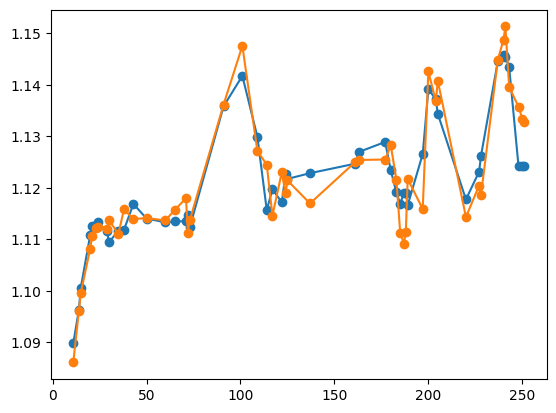

In [33]:
import matplotlib.pyplot as plt
plt.plot(df_test_pred_d1, marker='o')
plt.plot(df_test['Close_Day_1'], marker='o')

In [34]:
df_test_pred_d2 = pd.DataFrame(Y_test_pred[:,1], Y_test.index)

In [35]:
df_test_pred_d2 = df_test_pred_d2.sort_index()

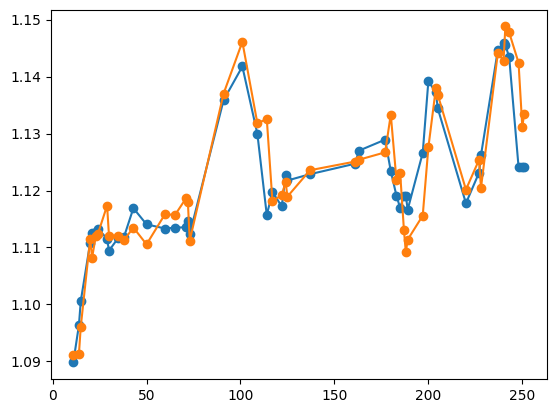

In [36]:
import matplotlib.pyplot as plt
plt.plot(df_test_pred_d1, marker='o')
plt.plot(df_test['Close_Day_2'], marker='o')

# Predict next 5 days

In [37]:
feats

,Date,opt_sine_offset,opt_sine_amp,opt_sine_freq,opt_sine_phase,opt_fourier_offset,opt_fourier_cosamp,opt_fourier_cosfreq,opt_fourier_cosphase,opt_fourier_sinamp,...,ROC1,ROC5,ROC20,WILLIAMS14,RSI14,CMO9,DEMA9,TEMA9,STOCH14,Close
0,2023-11-04,1.100596,1.005714,1.000547,-0.003069,1.103068,0.002586,1.184862,-6.501044,0.000928,...,-40.657913,-63.879897,-9.713451,-3340.465187,60.219153,31.373237,-0.017351,-0.012707,60.219153,1.11180
1,2023-11-03,1.098108,1.005885,1.000397,-0.003563,1.103094,0.243164,1.150903,-2.382430,-0.243039,...,-7.653997,-43.735403,71.426495,-3385.540476,54.088195,16.722381,-0.021735,-0.017618,54.088195,1.10454
2,2023-11-02,1.094267,1.559925,1.000684,-0.004143,1.103117,0.103859,1.002771,0.232754,0.103037,...,13.102248,-48.057418,91.329145,-4095.399719,52.708517,13.327550,-0.024258,-0.020081,52.708517,1.10306
3,2023-11-01,1.090227,1.003856,1.000474,-0.001870,1.103421,0.080181,0.942181,0.546254,0.080143,...,-31.632025,-53.066050,69.668410,-3809.096860,55.032730,19.990483,-0.027060,-0.023069,55.032730,1.10530
4,2023-10-31,1.089054,1.000000,0.999972,0.000913,1.103683,0.417155,1.218023,-4.798096,0.417929,...,-14.759869,-19.970363,97.892557,-3594.476727,47.431895,1.605056,-0.032075,-0.029578,47.431895,1.09739
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,2022-11-10,1.135797,1.000000,0.999469,0.003703,1.128380,-0.359253,0.946169,-0.097278,0.357739,...,-131.263727,-123.473165,-69.263247,-2920.799957,41.301430,-25.534425,0.008974,0.003676,41.301430,1.11779
258,2022-11-09,1.137712,1.000000,0.999799,0.003292,1.128581,0.143406,0.900329,0.006134,-0.144814,...,-10.616550,-43.274548,-151.740204,-2980.819778,53.863383,4.966191,0.016430,0.013208,53.863383,1.13713
259,2022-11-08,1.140011,1.000000,0.999322,0.004094,1.128165,0.003162,0.959386,1.383389,0.002139,...,137.390784,-36.069304,-206.716134,-3174.120453,55.276003,8.588288,0.017073,0.013468,55.276003,1.13888
260,2022-11-07,1.145152,1.956111,0.999343,0.004157,1.127908,0.297975,0.928827,-0.093774,-0.297015,...,-27.546780,-78.871223,-132.574585,-3200.657310,48.429680,-10.042125,0.017053,0.012691,48.429680,1.12934


In [38]:
def prepare_for_pred(df: pd.DataFrame, n_lag_features: int = 10):
    df = df.copy()
    df.drop(['t'], axis=1)
    X = []
    
    for col in df.columns:
        if col == 'Date':
            X.append(df[col])
        elif col != 'Close':
            col_lag_features = pd.DataFrame()
            for i in range(n_lag_features):
                lag_feature_name = f'{col}_Lag_{i}'
                col_lag_features[lag_feature_name] = df[col].shift(-i)
            X.append(col_lag_features)
        
    df = pd.concat(X, axis=1)
    df.dropna(inplace=True)
    return df


In [39]:
input_feats = prepare_for_pred(feats, n_lag_features).iloc[[0]]
input_feats

,Date,opt_sine_offset_Lag_0,opt_sine_offset_Lag_1,opt_sine_offset_Lag_2,opt_sine_offset_Lag_3,opt_sine_offset_Lag_4,opt_sine_offset_Lag_5,opt_sine_offset_Lag_6,opt_sine_offset_Lag_7,opt_sine_offset_Lag_8,...,STOCH14_Lag_0,STOCH14_Lag_1,STOCH14_Lag_2,STOCH14_Lag_3,STOCH14_Lag_4,STOCH14_Lag_5,STOCH14_Lag_6,STOCH14_Lag_7,STOCH14_Lag_8,STOCH14_Lag_9
0,2023-11-04,1.100596,1.098108,1.094267,1.090227,1.089054,1.087868,1.086111,1.087234,1.089257,...,60.219153,54.088195,52.708517,55.03273,47.431895,42.490729,39.567122,32.251386,32.788466,36.436717


In [40]:
input_feats = input_feats.drop(columns=['Date'])
input_feats

,opt_sine_offset_Lag_0,opt_sine_offset_Lag_1,opt_sine_offset_Lag_2,opt_sine_offset_Lag_3,opt_sine_offset_Lag_4,opt_sine_offset_Lag_5,opt_sine_offset_Lag_6,opt_sine_offset_Lag_7,opt_sine_offset_Lag_8,opt_sine_offset_Lag_9,...,STOCH14_Lag_0,STOCH14_Lag_1,STOCH14_Lag_2,STOCH14_Lag_3,STOCH14_Lag_4,STOCH14_Lag_5,STOCH14_Lag_6,STOCH14_Lag_7,STOCH14_Lag_8,STOCH14_Lag_9
0,1.100596,1.098108,1.094267,1.090227,1.089054,1.087868,1.086111,1.087234,1.089257,1.090748,...,60.219153,54.088195,52.708517,55.03273,47.431895,42.490729,39.567122,32.251386,32.788466,36.436717


In [41]:
input_feats_scaled = scaler.transform(input_feats)

In [42]:
input_feats_scaled_reduced = pca.transform(input_feats_scaled)

In [43]:
preds_scaled = pd.DataFrame()
for i in range(1, n_days_ahead + 1):
    preds_scaled[f'Close_Day_{i}'] = svrs[i-1].predict(input_feats_scaled_reduced)
preds_scaled

,Close_Day_1,Close_Day_2,Close_Day_3,Close_Day_4,Close_Day_5
0,-0.491562,-0.312658,-0.378628,-0.313457,-0.087007


In [44]:
preds_unscaled = scaler_y.inverse_transform(preds_scaled)

In [45]:
pd.DataFrame(preds_unscaled, columns=preds_scaled.columns)

,Close_Day_1,Close_Day_2,Close_Day_3,Close_Day_4,Close_Day_5
0,1.116015,1.118014,1.117092,1.117952,1.120615


In [46]:
outfile = 'predictions_T_svr.csv'

# Save the NumPy matrix to the CSV file (append mode)
with open(outfile, 'a') as f:
    np.savetxt(f, preds_unscaled, delimiter=',')